<a href="https://colab.research.google.com/github/Pravee0305/NLP_Assignment-1/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sample Text: SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used...


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


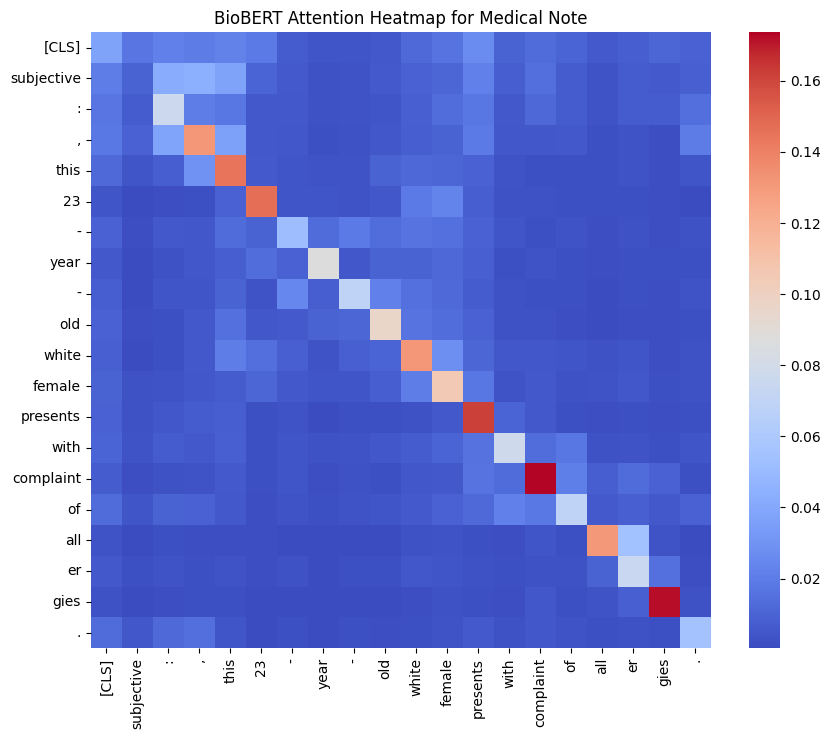

In [4]:
# Step 1: Import Necessary Libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 2: Load Dataset and Preprocess
# Load dataset
file_path = "/content/mtsamples.csv"
data = pd.read_csv(file_path)

# Check for missing values and drop them
data = data.dropna(subset=["transcription"])

# Select a sample medical note
sample_text = data["transcription"].iloc[0]

# Trim long text for better visualization
max_len = 50
words = sample_text.split()
if len(words) > max_len:
    sample_text = " ".join(words[:max_len]) + "..."

print("Sample Text:", sample_text)

# Step 3: Load BioBERT Model
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

# Step 4: Tokenize and Extract Attention Scores
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=128)

# Get model outputs
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # Tuple of attention matrices

# Extract last layer's attention
attention = attentions[-1]  # Shape: (batch, heads, seq_len, seq_len)

# Average across attention heads
attention = attention.mean(dim=1).squeeze().numpy()  # Shape: (seq_len, seq_len)

# Convert token IDs to words
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

# Convert [CLS] and [SEP] into more readable format
tokens = [t.replace("##", "") for t in tokens]

# Step 5: Visualize Attention Heatmap
# Reduce matrix size for better visualization (if long text)
seq_len = min(len(tokens), 20)  # Display first 20 tokens only
attention = attention[:seq_len, :seq_len]

plt.figure(figsize=(10, 8))
sns.heatmap(attention, xticklabels=tokens[:seq_len], yticklabels=tokens[:seq_len], cmap="coolwarm")
plt.title("BioBERT Attention Heatmap for Medical Note")
plt.xticks(rotation=90)
plt.show()
